In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import numpy as np
import warnings
from detoxify import Detoxify

pd.set_option('display.max_colwidth', None)
tqdm.pandas()
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
reduced_data = pd.read_csv("/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/cleaned_data.csv")
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745941 entries, 0 to 745940
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   date          745941 non-null  object
 1   cleanedTweet  745941 non-null  object
dtypes: object(2)
memory usage: 11.4+ MB


In [2]:
with open('analysis_results/sentiment_results.json') as f:
    results = json.load(f)
print(f"{len(results)} entries in JSON file")

745941 entries in JSON file


In [3]:
candidate_labels = ['USA started the war',
                    'POTUS started the war',
                    'Joe Biden started the war',
                    'CIA started the war',
                    'USA influenced the war',
                    'POTUS influenced the war',
                    'Joe Biden influenced the war',
                    'CIA influenced the war']

In [4]:
label_scores = {label: [] for label in candidate_labels}
for scores in results.values():
    for l, s in scores.items():
        label_scores[l].append(s)

In [5]:
def plot_histogram(label_scores):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
    axs = axs.flatten()
    final_plot = len(label_scores)

    for i, (label, scores) in enumerate(label_scores.items()):
        axs[i].hist(scores, bins=50, range=(0, 1))
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Histogram for "{label}"')
        axs[i].set_yscale('log')

    all_scores = [value for values in label_scores.values() for value in values]
    axs[final_plot].hist(all_scores, bins=50, range=(0, 1))
    axs[final_plot].set_xlabel('Value')
    axs[final_plot].set_ylabel('Frequency')
    axs[final_plot].set_title("Histogram for All Prompts")
    axs[final_plot].set_yscale('log')

    plt.tight_layout()
    plt.show()

    counts, bins = np.histogram(all_scores, bins=10, range=(0, 1))

    for i, count in enumerate(counts):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        print(f"{lower_bound:.2f} - {upper_bound:.2f}: {count}")


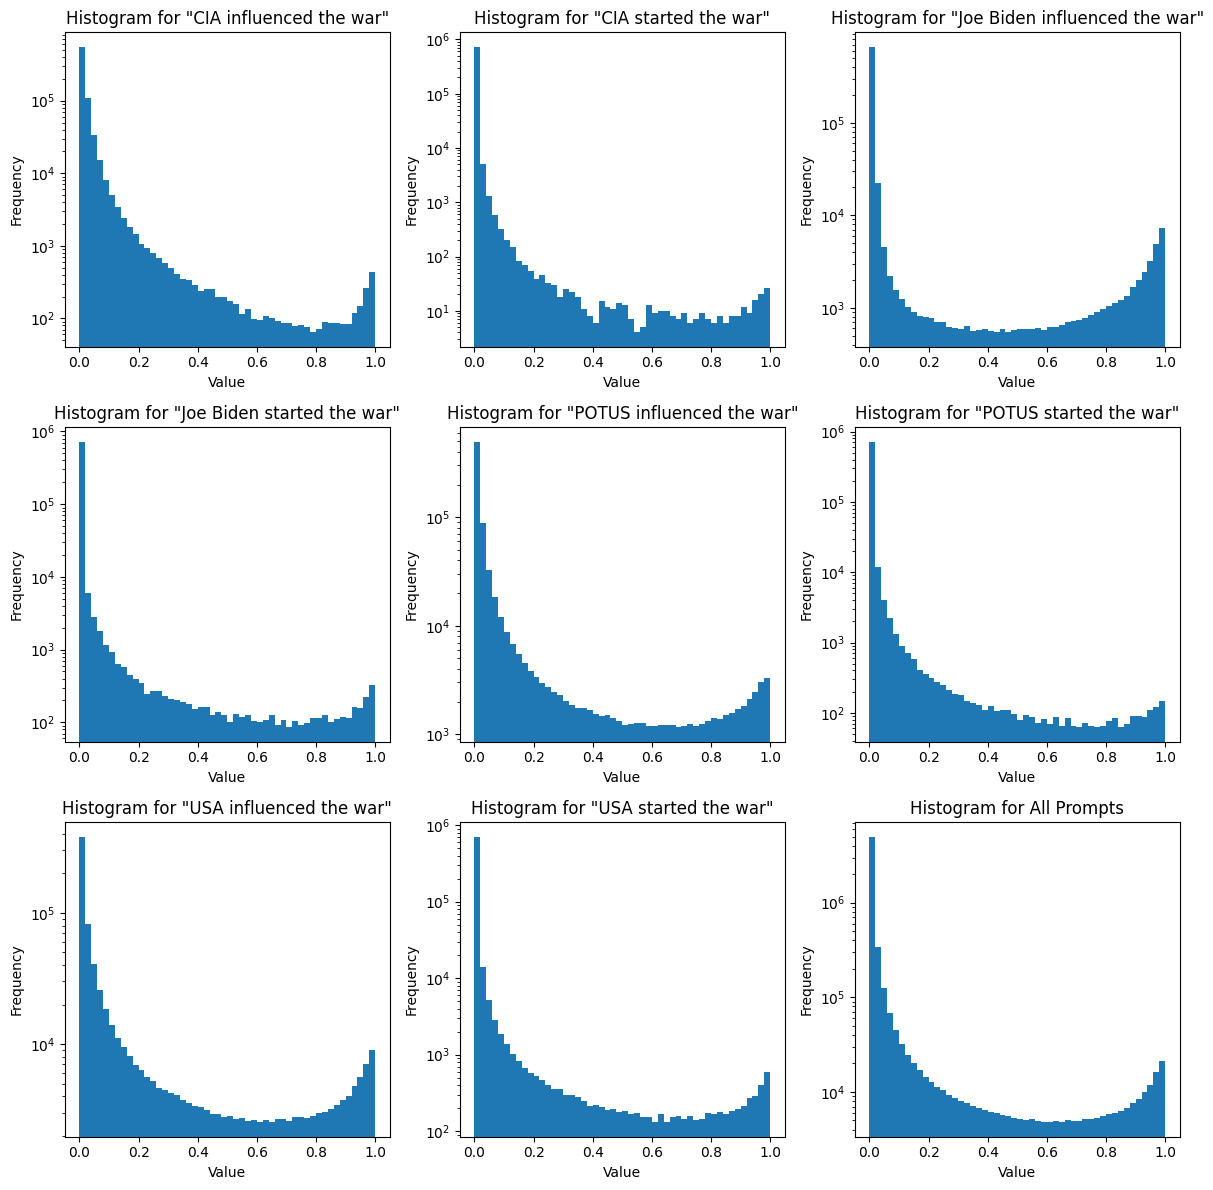

0.00 - 0.10: 5565897
0.10 - 0.20: 108774
0.20 - 0.30: 52352
0.30 - 0.40: 35942
0.40 - 0.50: 28708
0.50 - 0.60: 25176
0.60 - 0.70: 24550
0.70 - 0.80: 26098
0.80 - 0.90: 32691
0.90 - 1.00: 67340


In [6]:
label_scores = dict(sorted(label_scores.items()))
plot_histogram(label_scores)

In [7]:
tweets_per_threshold = {
    0.6: 0,
    0.7: 0,
    0.75: 0,
    0.8: 0,
    0.9: 0,
    0.95: 0,
}
for tweet, scores in results.items():
    for threshold in tweets_per_threshold.keys():
        if any(score > threshold for score in scores.values()):
            tweets_per_threshold[threshold] += 1

for threshold, count in tweets_per_threshold.items():
    print(f"{threshold}: {count} tweets ({round(count / len(results) * 100, 2)}%)")

0.6: 108841 tweets (14.59%)
0.7: 93688 tweets (12.56%)
0.75: 85444 tweets (11.45%)
0.8: 76683 tweets (10.28%)
0.9: 54043 tweets (7.24%)
0.95: 36123 tweets (4.84%)


In [ ]:
toxify = Detoxify('original')
toxicity_scores = {
    'toxicity': [],
    'severe_toxicity': [],
    'obscene': [],
    'threat': [],
    'insult': [],
    'identity_attack': [],
}
for tweet in tqdm(results.keys()):
    result = toxify.predict(tweet)
    for label, score in result.items():
        toxicity_scores[label].append(score)

In [ ]:
plot_histogram(toxicity_scores)

In [5]:
tweet_scores = []
for tweet, scores in results.items():
    max_pair = max(scores.items(), key=lambda x: x[1])
    tweet_scores.append((tweet, max_pair[0], max_pair[1], 0.9 - max_pair[1]))

just_below = [(t, l, s, d) for (t, l, s, d) in tweet_scores if d < 0]
just_above = [(t, l, s, d) for (t, l, s, d) in tweet_scores if d >= 0]

In [6]:
import operator

print("Below")
just_above.sort(key=operator.itemgetter(3))
for (t, l, s, _) in just_above[:20]:
    print(f"{t}:\n\t{l}: {s}")

print("Above")
just_below.sort(key=operator.itemgetter(3), reverse=True)
for (t, l, s, _) in just_below[:20]:
    print(f"{t}:\n\t{l}: {s}")

Below
/ Ukraine Russia POTUS NATO Russian report: The Armed Forces of Ukraine placed near the village of Dmitrovka in the Donbass anti-aircraft missile system "Osa".:
	POTUS influenced the war: 0.8999887704849243
Lying propagandist media shouting invasion over Ukraine, yet remain silent on the ACTUAL INVASION of America at our southern border.:
	USA influenced the war: 0.8999866843223572
What an embarrassing press conference. Blaming everyone else for his inflation because of his policies and basically giving Russia a green light to invade. Not to mention the question he didn't answer about China and his son. Disgusting:
	POTUS influenced the war: 0.8999812006950378
Many of us do stand with Ukraine against Russian hegemony. But not the case with Trump and the Republican party. Cant have it both ways Brian by defending Ukraine yet knowing that Trump is fine with Putins military action. You will fall in line w/ Trump Mr. Independent Voice.:
	POTUS influenced the war: 0.8999676704406738
H